In [1]:
import os
import numpy as np
import pandas as pd
import librosa
from librosa import display
from matplotlib import pyplot as plt
import IPython.display as ipd
from torchaudio.transforms import AmplitudeToDB, MelSpectrogram

from tqdm import tqdm, notebook
from sklearn.model_selection import train_test_split
from DESED_task.desed_task.nnet.CRNN import CRNN
import torch
import yaml
from pathlib import Path

DATA_DIR = Path(r"C:\Users\Owner\PythonProjects\DCASE\DCASE2021\data")

In [3]:
sr = 16000

audio_path = DATA_DIR / "raw_datasets/desed_real/audio/train/weak"
train_audios = os.listdir(audio_path)
metadata = pd.read_csv(str(audio_path).replace("audio", "metadata") + ".tsv", sep="\t")
metadata = metadata[metadata["filename"].isin(train_audios)]
metadata

filename                       event_labels
0       YKK227gPpRn4_30.000_40.000.wav          Alarm_bell_ringing,Speech
1        Y-6p32k2WUCs_0.000_10.000.wav                 Alarm_bell_ringing
2         Y-Zjgm_sZd10_0.000_4.000.wav                 Alarm_bell_ringing
3         Y-ikrSfqB0LU_0.000_3.000.wav                 Alarm_bell_ringing
4        Y26ubekDhG_Y_0.000_10.000.wav                 Alarm_bell_ringing
...                                ...                                ...
1309  YUW0vfC5UjQg_140.000_150.000.wav  Electric_shaver_toothbrush,Speech
1310    YiDBWBvuYOQk_30.000_40.000.wav  Electric_shaver_toothbrush,Speech
1311    Yqc61mzzSIxM_30.000_40.000.wav  Electric_shaver_toothbrush,Speech
1312  YyfSco9z1fpw_190.000_200.000.wav  Electric_shaver_toothbrush,Speech
1313    YyixVwsu3pvc_40.000_50.000.wav  Electric_shaver_toothbrush,Speech

[1314 rows x 2 columns]

(160000,)


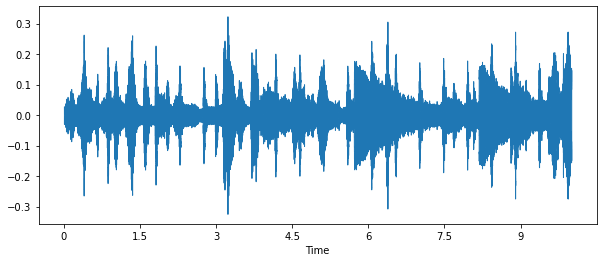

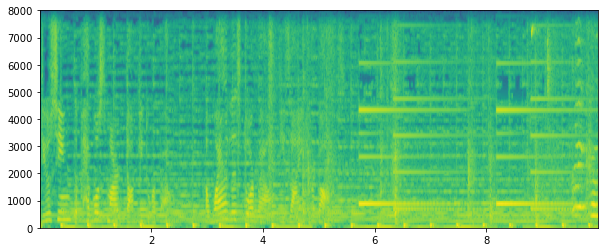

In [95]:
# look at one audio
first_audio_path = str(audio_path) + "/" + metadata.loc[0, "filename"]
audio = librosa.load(first_audio_path, sr=16000)[0]
print(audio.shape)
plt.figure(figsize=(10, 4))
display.waveshow(audio, sr=sr)
plt.show()
plt.figure(figsize=(10, 4))
plt.specgram(audio, Fs=sr)
plt.show()
ipd.Audio(first_audio_path)

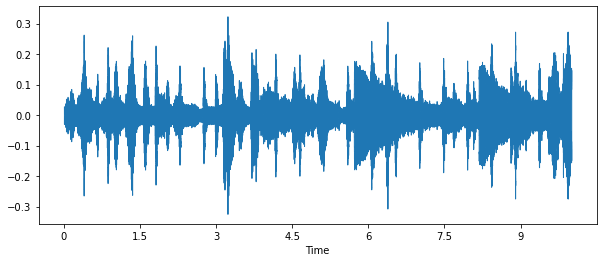

In [26]:
plt.figure(figsize=(10, 4))
display.waveshow(audio, sr=sr)
ipd.Audio(first_audio_path)

In [3]:
with open("../confs/sed.yaml", "r") as f:
    configs = yaml.safe_load(f)

In [8]:
import torch
import torchaudio
import torchaudio.functional as F

In [11]:
effects = [
  ["lowpass", "-1", "300"], # apply single-pole lowpass filter
  ["speed", "0.8"],  # reduce the speed
                     # This only changes sample rate, so it is necessary to
                     # add `rate` effect with original sample rate after this.
  ["rate", f"{sr}"],
  ["reverb", "-w"],  # Reverbration gives some dramatic feeling
]

waveform2, sample_rate2 = torchaudio.sox_effects.apply_effects_tensor(
    torch.Tensor(audio), sr, effects)

RuntimeError: torchaudio.sox_effects.sox_effects.apply_effects_tensor requires sox

In [12]:
audio_path

WindowsPath('C:/Users/Owner/PythonProjects/DCASE/DCASE2021/data/raw_datasets/desed_real/audio/train/weak')

In [55]:
def compare_audios(audios, titles=None, sr=16000):
    figure, ax = plt.subplots(len(audios), 2, figsize=(16,  len(audios) * 4))
    if titles is None:
        titles = [""] * len(audios)
    for i, audio in enumerate(audios):
        display.waveshow(audio, sr=sr, ax=ax[i, 0])
        ax[i, 1].set_title(titles[i])
        ax[i, 1].specgram(audio, Fs=sr)

    plt.show()

In [128]:
def add_noise(data, noise_factor):
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    # Cast back to same data type
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data

def add_shift(data, shift_max, shift_direction):
    shift = np.random.randint(sr * shift_max)
    if shift_direction == 'right':
        shift = -shift
    elif shift_direction == 'both':
        direction = np.random.randint(0, 2)
        if direction == 1:
            shift = -shift
    augmented_data = np.roll(data, shift)
    # Set to silence for heading/ tailing
    if shift > 0:
        augmented_data[:shift] = 0
    else:
        augmented_data[shift:] = 0
    return augmented_data

def add_pitch_shift(data, pitch_factor):
    return librosa.effects.pitch_shift(data, sr=sr, n_steps=pitch_factor)

def add_time_stretch(data, speed_factor):
    return librosa.effects.time_stretch(data, rate=speed_factor)

def add_time_mask(data, max_offset=0.1):
    onset = int(np.random.rand() * len(data))
    offset = int(np.random.uniform(high=max_offset) * len(data))
    masked = np.copy(data)
    masked[onset:onset + offset] = np.mean(data)
    return masked

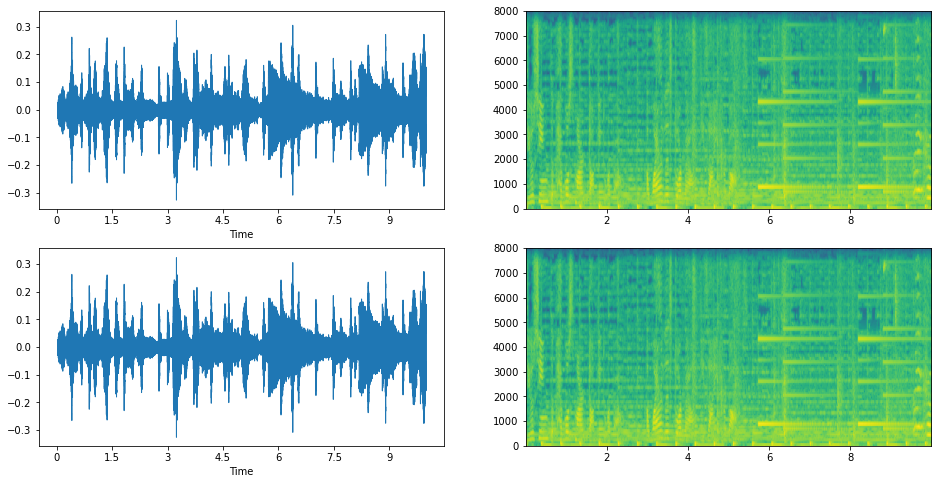

In [129]:
compare_audios([audio, add_pitch_mask(audio)])

C:\Users\Owner\anaconda3\envs\dcase2021\lib\site-packages\matplotlib\axes\_axes.py:7626: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)
C:\Users\Owner\anaconda3\envs\dcase2021\lib\site-packages\matplotlib\axes\_axes.py:7626: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


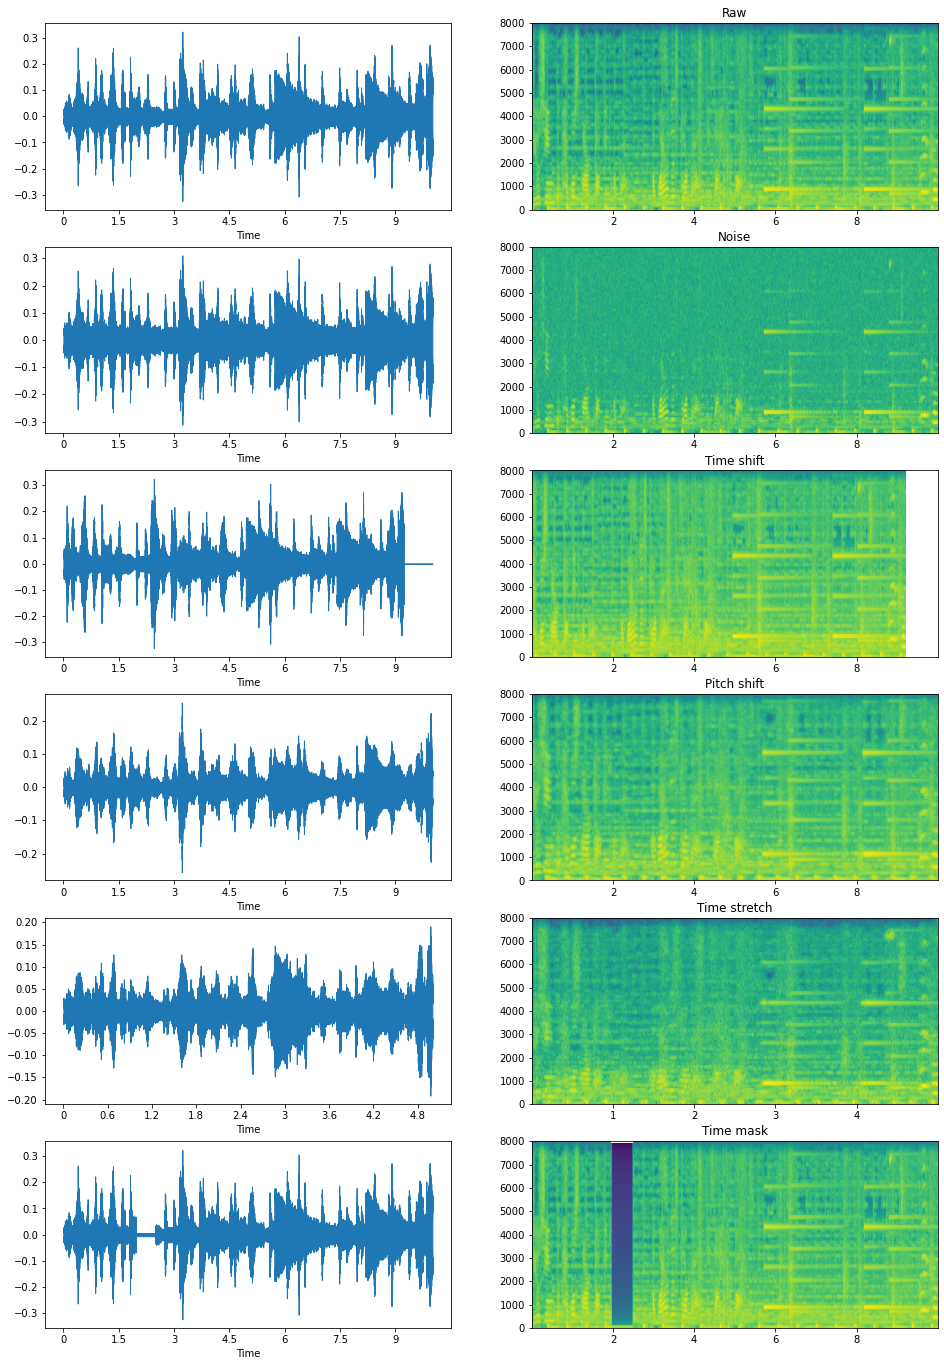

In [130]:
compare_audios([
    audio,
    add_noise(audio, 0.01),
    add_shift(audio, 1, "right"),
    add_pitch_shift(audio, 4),
    add_time_stretch(audio, 2),
    add_time_mask(audio),
], titles=["Raw", "Noise", "Time shift", "Pitch shift", "Time stretch", "Time mask"])

In [22]:
ipd.Audio(manipulate(audio_1[0], noise_factor=0.01), rate=sr)

In [54]:
librosa.effects.

(160000,)

In [23]:
def add_shift(data, sampling_rate, shift_max, shift_direction):
    shift = np.random.randint(sampling_rate * shift_max)
    if shift_direction == 'right':
        shift = -shift
    elif shift_direction == 'both':
        direction = np.random.randint(0, 2)
        if direction == 1:
            shift = -shift
    augmented_data = np.roll(data, shift)
    # Set to silence for heading/ tailing
    if shift > 0:
        augmented_data[:shift] = 0
    else:
        augmented_data[shift:] = 0
    return augmented_data

In [37]:
def add_pitch_shift(data, sampling_rate, pitch_factor):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

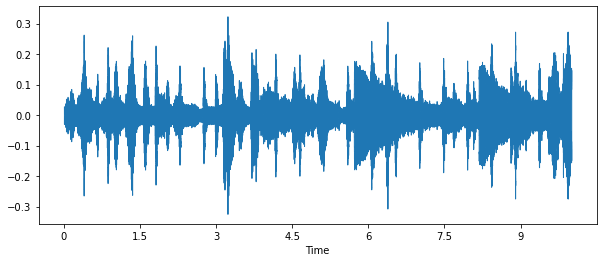

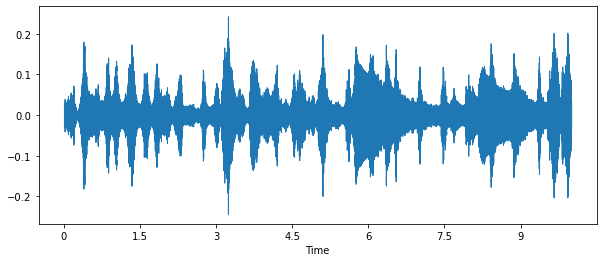

In [49]:
plt.figure(figsize=(10, 4))
display.waveshow(audio_1[0], sr=sr)
plt.figure(figsize=(10, 4))
display.waveshow(manipulate(audio_1[0], sr, pitch_factor=10), sr=sr)

In [51]:
ipd.Audio(manipulate(audio_1[0], sr, pitch_factor=4), rate=sr)

In [56]:
def add_time_stretch(data, speed_factor):
    return librosa.effects.time_stretch(data, rate=speed_factor)

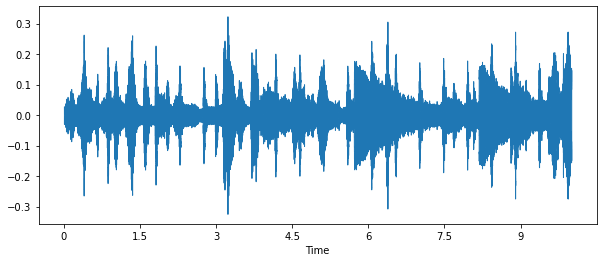

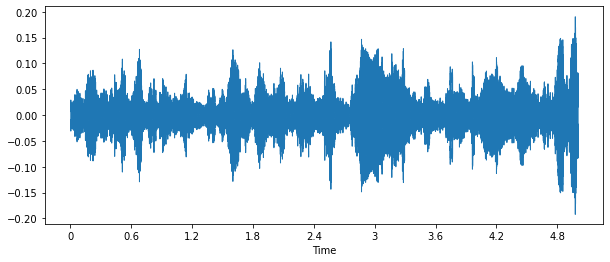

In [57]:
plt.figure(figsize=(10, 4))
display.waveshow(audio_1[0], sr=sr)
plt.figure(figsize=(10, 4))
display.waveshow(manipulate(audio_1[0], 2), sr=sr)

In [59]:
ipd.Audio(manipulate(audio_1[0], 0.5), rate=sr)